In [1]:
import xgboost as xgb   # model training
from xgboost.sklearn import XGBRegressor
import pickle           # save model
from sklearn.model_selection import GridSearchCV
from sklearn import metrics   # Additional scklearn functions

import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pylab as plt
%matplotlib inline

ref: https://blog.csdn.net/weiyongle1996/article/details/78360873

In [10]:
%run 103-data_preprocessing.py

In [6]:
default_params = {
    'learning_rate': 0.1,
    'n_estimators': 500,
    'max_depth': 5,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree':0.8,
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'objective': 'reg:squarederror'
}

In [25]:
def model_fit(model: xgb.XGBRegressor or xgb.XGBRegressor, 
              X: pd.DataFrame or np.array or list, 
              y: pd.DataFrame or np.array or list, 
              useTrainCV=True,
              cv_folds=5,
              early_stopping_rounds=50
              ) -> None:
    
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, label=y.values)
        cvresult = xgb.cv(xgb_param, 
                          xgtrain, 
                          num_boost_round=model.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics='rmse', 
                          early_stopping_rounds=early_stopping_rounds,
                          verbose_eval=True
                          )
        model.set_params(n_estimators=cvresult.shape[0])

    # fit the algorithm on the data
    model.fit(X, y, eval_metric='rmse')
    
    # predict training set
    dtrain_predictions = model.predict(X)
    # dtrain_predprob = model.predict_proba(X)[:,1]
    
    # print model report
    print('*'*10)
    print("Model Report")
    print("rmse : %.4g" % metrics.mean_squared_error(y.values, dtrain_predictions))
    print('r2_score : %.4g' % metrics.r2_score(y.values, dtrain_predictions))
    print('*'*10)
    
    sns.set_style('whitegrid')
    feat_imp = (pd.Series(model.get_booster().get_fscore())
                .sort_values(ascending=False))
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    return model

## 1 - Confirm the parameters by cross-validation

[0]	train-rmse:0.46132+0.00018	test-rmse:0.46217+0.00020
[1]	train-rmse:0.42724+0.00038	test-rmse:0.42902+0.00043
[2]	train-rmse:0.39715+0.00034	test-rmse:0.39991+0.00054
[3]	train-rmse:0.37061+0.00048	test-rmse:0.37451+0.00070
[4]	train-rmse:0.34747+0.00047	test-rmse:0.35255+0.00096
[5]	train-rmse:0.32735+0.00052	test-rmse:0.33364+0.00110
[6]	train-rmse:0.30968+0.00051	test-rmse:0.31719+0.00138
[7]	train-rmse:0.29439+0.00055	test-rmse:0.30323+0.00159
[8]	train-rmse:0.28114+0.00052	test-rmse:0.29132+0.00188
[9]	train-rmse:0.26972+0.00053	test-rmse:0.28124+0.00210
[10]	train-rmse:0.26001+0.00065	test-rmse:0.27272+0.00220
[11]	train-rmse:0.25161+0.00065	test-rmse:0.26548+0.00226
[12]	train-rmse:0.24448+0.00066	test-rmse:0.25935+0.00240
[13]	train-rmse:0.23818+0.00068	test-rmse:0.25429+0.00247
[14]	train-rmse:0.23275+0.00067	test-rmse:0.25017+0.00256
[15]	train-rmse:0.22824+0.00069	test-rmse:0.24676+0.00271
[16]	train-rmse:0.22430+0.00077	test-rmse:0.24395+0.00284
[17]	train-rmse:0.22082+

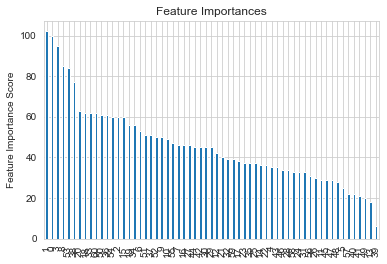

In [27]:
xgb1 = XGBRegressor(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    # objective='reg:squarederror',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=3612
                    )

xgb2 = model_fit(xgb1, X_train_t2, y_train_t2)

In [28]:
xgb2.objective

'reg:squarederror'

In [29]:
print('best n_estimators:', xgb2.get_params()['n_estimators'])
print('best max_depth:', xgb2.get_params()['max_depth'])
print('best min_child_weight:', xgb2.get_params()['min_child_weight'])
print('best gamma:', xgb2.get_params()['gamma'])
print('best subsample:', xgb2.get_params()['subsample'])
print('best colsample_bytree:', xgb2.get_params()['colsample_bytree'])


best n_estimators: 112
best max_depth: 5
best min_child_weight: 1
best gamma: 0
best subsample: 0.8
best colsample_bytree: 0.8


best n_estimators: 112

## 2 - Optimize `max_depth` and `min_child_weight` by grid search

In [30]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, 
                                                  n_estimators=112, 
                                                  max_depth=5, min_child_weight=1,
                                                  gamma=0,
                                                  subsample=0.8,
                                                  colsample_bytree=0.8,
                                                  objective='reg:squarederror',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  seed=3612
                                                  ), 
                        param_grid = param_test1, 
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=4, 
                        cv=5
                        )

gsearch1.fit(X_train_t2, y_train_t2)
gsearch1.cv_results_, gsearch1.best_score_, gsearch1.best_params_

({'mean_fit_time': array([11.53361177, 11.11565037, 10.88749161, 18.9358851 , 18.48589067,
         17.71563191, 28.6173131 , 29.09336176, 26.08350983, 40.17208209,
         37.65340624, 47.99169369]),
  'std_fit_time': array([0.51525033, 0.32582107, 0.39177702, 0.27663996, 0.1970319 ,
         0.64307448, 0.65404413, 0.77844879, 0.97110686, 1.50258549,
         3.40386323, 3.97258281]),
  'mean_score_time': array([0.033602  , 0.03517585, 0.03768778, 0.04139948, 0.03598542,
         0.03389935, 0.03824248, 0.0340312 , 0.03403649, 0.03755522,
         0.04506536, 0.04047484]),
  'std_score_time': array([0.00550466, 0.00640595, 0.00569807, 0.00887341, 0.008682  ,
         0.00424648, 0.00773782, 0.00263699, 0.00288487, 0.00732401,
         0.01694588, 0.00990056]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?

In [31]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[2,3,4]
}

gsearch2 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1,
                                                  n_estimators=112,
                                                  max_depth=3, 
                                                  min_child_weight=3, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective='reg:squarederror', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=3612), 
                        param_grid = param_test2, 
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=4,
                        cv=5
                        )

gsearch2.fit(X_train_t2, y_train_t2)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_


({'mean_fit_time': array([11.25142717,  8.69907441,  8.99370289, 19.467693  , 14.80858736,
         16.54170747, 18.320469  , 14.33919621, 20.28525681]),
  'std_fit_time': array([1.53156564, 0.65751949, 0.40143008, 2.10745373, 1.46293193,
         1.44496375, 1.71969814, 1.18904723, 3.34330099]),
  'mean_score_time': array([0.04119363, 0.031563  , 0.03676267, 0.03839002, 0.03200636,
         0.03905001, 0.03748269, 0.03954229, 0.034654  ]),
  'std_score_time': array([0.00378327, 0.00741699, 0.00407562, 0.00853049, 0.01155817,
         0.01053373, 0.00451152, 0.00784163, 0.00589443]),
  'param_max_depth': masked_array(data=[2, 2, 2, 3, 3, 3, 4, 4, 4],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[2, 3, 4, 2, 3, 4, 2, 3, 4],
               mask=[False, False, False, False, False, False, False, False,
                     False],


In [32]:
means = gsearch2.cv_results_["mean_test_score"]
stdevs = gsearch2.cv_results_["std_test_score"]
params = gsearch2.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.230187 (0.003179) with: {'max_depth': 2, 'min_child_weight': 2}
-0.230099 (0.003123) with: {'max_depth': 2, 'min_child_weight': 3}
-0.230174 (0.002911) with: {'max_depth': 2, 'min_child_weight': 4}
-0.228044 (0.002108) with: {'max_depth': 3, 'min_child_weight': 2}
-0.227794 (0.002304) with: {'max_depth': 3, 'min_child_weight': 3}
-0.227976 (0.002070) with: {'max_depth': 3, 'min_child_weight': 4}
-0.227756 (0.002692) with: {'max_depth': 4, 'min_child_weight': 2}
-0.227593 (0.002225) with: {'max_depth': 4, 'min_child_weight': 3}
-0.227536 (0.003044) with: {'max_depth': 4, 'min_child_weight': 4}


-0.2275362700083306

---

'max_depth': 4, 'min_child_weight': 4

## 3 - Optimize `gamma` by grid search

In [55]:
param_test3 = {
 'gamma': [i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, 
                                                  n_estimators=112, max_depth=4, min_child_weight=4,
                                                  gamma=0, 
                                                  subsample=0.8,
                                                  colsample_bytree=0.8, 
                                                  objective='reg:squarederror', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=3612), 
                        param_grid = param_test3, 
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=4,
                        cv=5
                        )

gsearch3.fit(X_train_t2, y_train_t2)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([29.1753315 , 23.33082743, 26.96825457, 25.59523654, 12.34519086]),
  'std_fit_time': array([3.61223724, 1.54363916, 1.3689214 , 1.35717528, 4.13195505]),
  'mean_score_time': array([0.03813014, 0.04707613, 0.04399328, 0.03038821, 0.02771277]),
  'std_score_time': array([0.00390176, 0.01703808, 0.00546402, 0.00179683, 0.00367296]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([-0.22227785, -0.22321591, -0.22213344, -0.22285173, -0.22289074]),
  'split1_test_score': array([-0.23130641, -0.2324663 , -0.23118253, -0.23212394, -0.23171412]),
  'split2_test_score': array([-0.22645746, -0.22668538, -0.22678083, -0.2272835 , -0.22736424]),
  'split3_test_score': array([-0.2287495 , -0.22810581, -0.22781255, -0

In [ ]:
means = gsearch3.cv_results_["mean_test_score"]
stdevs = gsearch3.cv_results_["std_test_score"]
params = gsearch3.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.2273519479841975

---

'gamma': 0.2

## 4 - Optimize `subsample` and `colsample_bytree` by grid search

In [56]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, 
                                                  n_estimators=112, max_depth=4, min_child_weight=4, gamma=0.2, 
                                                  objective='reg:squarederror', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=3612), 
                        param_grid = param_test4, 
                        scoring='neg_root_mean_squared_error',
                        n_jobs=4,
                        cv=5
                        )

gsearch4.fit(X_train_t2, y_train_t2)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([13.43250113, 12.72933846, 11.98848763, 12.24443474, 13.45553493,
         13.08807688, 13.08721843, 13.36330943, 13.77883253, 14.57550116,
         18.69550028, 20.14128718, 16.31087637, 15.65098462, 16.55107698,
         15.64585271]),
  'std_fit_time': array([0.42339773, 0.28197249, 0.39704169, 0.17949768, 0.16512422,
         0.42654955, 0.27963476, 0.04059705, 0.24543699, 1.15912641,
         1.68442362, 0.33860387, 0.62786022, 0.16594462, 0.18409068,
         0.62059162]),
  'mean_score_time': array([0.07427478, 0.03375726, 0.03047194, 0.0296957 , 0.03286085,
         0.0331749 , 0.03600612, 0.03056097, 0.04477301, 0.03668938,
         0.03594117, 0.03738294, 0.0318028 , 0.04297547, 0.04137459,
         0.02969036]),
  'std_score_time': array([0.0502529 , 0.00276338, 0.0037757 , 0.00456095, 0.00368339,
         0.00201556, 0.01492942, 0.00447276, 0.01921509, 0.00492139,
         0.00663543, 0.00526835, 0.00601483, 0.00662062, 0.0108791 ,
         0.008097

In [59]:
param_test4a = {
    'subsample':[i/10.0 for i in range(4,7)], # tested 65, 70, 75; resulted in 65
    'colsample_bytree':[i/10.0 for i in range(4,7)] # tested 4, 5, 6; resulted in 4
}

gsearch4a = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, 
                                                  n_estimators=112, max_depth=4, min_child_weight=4, gamma=0.2, 
                                                  objective='reg:squarederror', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=3612), 
                        param_grid = param_test4a, 
                        scoring='neg_root_mean_squared_error',
                        n_jobs=4,
                        cv=5
                        )

gsearch4a.fit(X_train_t2, y_train_t2)
gsearch4a.cv_results_, gsearch4a.best_params_, gsearch4a.best_score_

({'mean_fit_time': array([10.91472902, 16.19703021, 12.60407505,  8.88514132, 12.03925147,
         10.42612352, 12.28584242, 11.83236051,  9.69912806]),
  'std_fit_time': array([1.44836959, 2.71164766, 5.76832087, 0.68064053, 1.17429331,
         0.77030136, 0.64839871, 0.47068329, 3.08348336]),
  'mean_score_time': array([0.035144  , 0.03852406, 0.0363637 , 0.03296032, 0.03191481,
         0.03393273, 0.02965922, 0.03126817, 0.02986021]),
  'std_score_time': array([0.0064073 , 0.00666218, 0.01004218, 0.00379155, 0.00747337,
         0.00335748, 0.00781364, 0.00176102, 0.00799745]),
  'param_colsample_bytree': masked_array(data=[0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.4, 0.5, 0.6, 0.4, 0.5, 0.6, 0.4, 0.5, 0.6],
               mask=[False, False, False, False, False, False, False, 

In [61]:
param_test4b = {
    'subsample':[i/100.0 for i in range(55,70,5)], # tested 65, 70, 75; resulted in 65
    'colsample_bytree':[i/100.0 for i in range(55,70,5)] # tested 4, 5, 6; resulted in 4
}

gsearch4b = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, 
                                                  n_estimators=112, max_depth=4, min_child_weight=4, gamma=0.2, 
                                                  objective='reg:squarederror', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=3612), 
                        param_grid = param_test4b, 
                        scoring='neg_root_mean_squared_error',
                        n_jobs=4,
                        cv=5
                        )

gsearch4b.fit(X_train_t2, y_train_t2)
gsearch4b.cv_results_, gsearch4b.best_params_, gsearch4b.best_score_

({'mean_fit_time': array([10.87361102, 10.20049324, 10.33820019, 10.5993856 , 11.38370557,
         11.09142079, 11.07718778, 16.04895563, 14.60999022]),
  'std_fit_time': array([0.37205068, 0.06303089, 0.15020432, 0.10291149, 0.15174232,
         0.15363943, 0.17411566, 2.37856208, 3.93054334]),
  'mean_score_time': array([0.03537178, 0.03791423, 0.03154688, 0.0318758 , 0.0376667 ,
         0.03442035, 0.03254251, 0.02859254, 0.04245663]),
  'std_score_time': array([0.00268599, 0.00978831, 0.00340213, 0.00648621, 0.00824013,
         0.00875542, 0.00992981, 0.00373936, 0.00843095]),
  'param_colsample_bytree': masked_array(data=[0.55, 0.55, 0.55, 0.6, 0.6, 0.6, 0.65, 0.65, 0.65],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.55, 0.6, 0.65, 0.55, 0.6, 0.65, 0.55, 0.6, 0.65],
               mask=[False, False, False, False, False, Fa

In [62]:
means = gsearch4b.cv_results_["mean_test_score"]
stdevs = gsearch4b.cv_results_["std_test_score"]
params = gsearch4b.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.228995 (0.003246) with: {'colsample_bytree': 0.55, 'subsample': 0.55}
-0.227389 (0.003400) with: {'colsample_bytree': 0.55, 'subsample': 0.6}
-0.227982 (0.003615) with: {'colsample_bytree': 0.55, 'subsample': 0.65}
-0.228597 (0.003736) with: {'colsample_bytree': 0.6, 'subsample': 0.55}
-0.226900 (0.003399) with: {'colsample_bytree': 0.6, 'subsample': 0.6}
-0.228551 (0.002786) with: {'colsample_bytree': 0.6, 'subsample': 0.65}
-0.228468 (0.003556) with: {'colsample_bytree': 0.65, 'subsample': 0.55}
-0.227066 (0.003658) with: {'colsample_bytree': 0.65, 'subsample': 0.6}
-0.228635 (0.002596) with: {'colsample_bytree': 0.65, 'subsample': 0.65}


-0.2268996267034788

---

subsample=0.6, colsample_bytree=0.6

## 5 - Optimize `reg_alpha` and `reg_lambda` by grid search

In [63]:
param_test5 = {
 'reg_alpha':[0, 0.01, 0.05, 0.07, 0.1, 0.5],
 'reg_lambda':[0, 0.01, 0.05, 0.07, 0.1, 0.5]
}
gsearch5 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, 
                                                 n_estimators=112, max_depth=4, min_child_weight=4, gamma=0.2, subsample=0.6, colsample_bytree=0.6, 
                                                 objective='reg:squarederror', 
                                                 nthread=4, 
                                                 scale_pos_weight=1,
                                                 seed=3612
                                                 ), 
                        param_grid = param_test5, 
                        scoring='neg_root_mean_squared_error',
                        n_jobs=4,
                        cv=5
                        )

gsearch5.fit(X_train_t2, y_train_t2)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([15.09029722, 21.37663875, 26.41666961, 14.70023909, 10.99091377,
         10.90000463, 12.44668217, 14.55811558, 25.60619226, 23.19687076,
         15.00071492, 11.14968438, 10.97429338, 10.88816748, 10.86296086,
         10.78288617, 10.80881839, 11.43254857, 12.07356343, 16.98517165,
         14.34078536, 11.43950448, 11.33336749, 11.49161425, 11.17828026,
         11.44063988, 11.37874327, 12.65987253, 12.8039072 , 11.76972914,
         12.24428625, 11.92416344, 11.54229045, 11.48779721, 11.46483965,
         11.02852187]),
  'std_fit_time': array([1.89937604, 2.89332436, 1.04518437, 6.02043988, 0.1657602 ,
         0.09509588, 1.39337505, 0.12695714, 1.65286538, 1.05871971,
         4.73360805, 0.10294289, 0.06850603, 0.05298382, 0.0527325 ,
         0.04282273, 0.11716172, 0.48493723, 0.15756221, 1.65074923,
         1.54678286, 0.09900835, 0.10942004, 0.10653385, 0.10558904,
         0.06797039, 0.04545584, 0.68635629, 0.60855118, 0.13191663,
         0.

In [64]:
param_test5a = {
 'reg_alpha':[0.05, 0.01, 0.02, 0.03, 0.04],
 'reg_lambda':[0.05, 0.01, 0.02, 0.03, 0.04]
}
gsearch5a = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, 
                                                  n_estimators=112, max_depth=4, min_child_weight=4, gamma=0.2, subsample=0.6, colsample_bytree=0.6,  
                                                  objective='reg:squarederror', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=3612
                                                  ), 
                        param_grid = param_test5a, 
                        scoring='neg_root_mean_squared_error',
                        n_jobs=4,
                        cv=5
                        )

gsearch5a.fit(X_train_t2, y_train_t2)
gsearch5a.cv_results_, gsearch5a.best_params_, gsearch5a.best_score_

({'mean_fit_time': array([10.92504144, 10.57912378, 10.62662807, 10.62053437, 10.76189694,
         10.83681769, 13.61869526, 16.62412872, 10.93911209, 12.41887727,
         11.96170378, 12.42582746, 11.22843342, 11.3533936 , 11.62268538,
         11.513451  , 11.34983315, 11.4518126 , 11.86832476, 11.70017495,
         11.52675743, 11.22926359, 11.1791925 , 11.68244305, 10.02308669]),
  'std_fit_time': array([0.16414536, 0.04463204, 0.06581831, 0.11563362, 0.11932256,
         0.1226227 , 2.15814375, 0.3750536 , 0.20686428, 1.00904246,
         1.21794099, 0.72837576, 0.08842701, 0.2371239 , 0.17928472,
         0.10713062, 0.05380481, 0.20253059, 0.18090273, 0.1710461 ,
         0.08765627, 0.16069313, 0.08355936, 0.21050062, 3.01888339]),
  'mean_score_time': array([0.02969627, 0.03167825, 0.03178616, 0.02579703, 0.02734685,
         0.03366704, 0.04798298, 0.03552227, 0.03319411, 0.02953877,
         0.03124099, 0.0291028 , 0.03084345, 0.0380127 , 0.03011141,
         0.03250899, 0

In [65]:
means = gsearch5a.cv_results_["mean_test_score"]
stdevs = gsearch5a.cv_results_["std_test_score"]
params = gsearch5a.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.227399 (0.003380) with: {'reg_alpha': 0.05, 'reg_lambda': 0.05}
-0.227841 (0.003665) with: {'reg_alpha': 0.05, 'reg_lambda': 0.01}
-0.227815 (0.003519) with: {'reg_alpha': 0.05, 'reg_lambda': 0.02}
-0.227673 (0.003666) with: {'reg_alpha': 0.05, 'reg_lambda': 0.03}
-0.227503 (0.003525) with: {'reg_alpha': 0.05, 'reg_lambda': 0.04}
-0.227861 (0.003725) with: {'reg_alpha': 0.01, 'reg_lambda': 0.05}
-0.227243 (0.004123) with: {'reg_alpha': 0.01, 'reg_lambda': 0.01}
-0.227601 (0.003780) with: {'reg_alpha': 0.01, 'reg_lambda': 0.02}
-0.227935 (0.003743) with: {'reg_alpha': 0.01, 'reg_lambda': 0.03}
-0.227869 (0.003798) with: {'reg_alpha': 0.01, 'reg_lambda': 0.04}
-0.227886 (0.003523) with: {'reg_alpha': 0.02, 'reg_lambda': 0.05}
-0.228004 (0.003873) with: {'reg_alpha': 0.02, 'reg_lambda': 0.01}
-0.228042 (0.003905) with: {'reg_alpha': 0.02, 'reg_lambda': 0.02}
-0.228149 (0.003610) with: {'reg_alpha': 0.02, 'reg_lambda': 0.03}
-0.227972 (0.003099) with: {'reg_alpha': 0.02, 'reg_lambda': 0

-0.22724253968064928

---

'reg_alpha': 0.01, 'reg_lambda': 0.01

## 6 - Optimize `learning_rate` by grid search

In [66]:
param_test6 = {
    'learning_rate':[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
}

gsearch6 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1,
                                                  n_estimators=112, max_depth=4, min_child_weight=4, gamma=0.2, 
                                                  subsample=0.6, colsample_bytree=0.6,
                                                  reg_alpha=0.01, reg_lambda=0.01, 
                                                  objective='reg:squarederror', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=3612
                                                  ), 
                        param_grid = param_test6,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=4,
                        cv=5
                        )

gsearch6.fit(X_train_t2, y_train_t2)
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_
    

({'mean_fit_time': array([15.92984624, 23.00797625, 17.6858304 , 12.02904201, 12.2625773 ,
         11.70203319, 12.18125954, 11.9290802 , 11.48266382,  9.58551798]),
  'std_fit_time': array([3.14454289, 1.15025379, 5.1651717 , 0.51955929, 0.21726851,
         0.09079303, 0.45626041, 0.33565472, 0.15159512, 2.42825114]),
  'mean_score_time': array([0.03327613, 0.03630438, 0.03519764, 0.02905302, 0.03798113,
         0.03057938, 0.03647385, 0.03027329, 0.03212643, 0.03178539]),
  'std_score_time': array([0.00127097, 0.00809294, 0.01007599, 0.00222062, 0.00891893,
         0.00621281, 0.01509186, 0.0057461 , 0.00968788, 0.00570605]),
  'param_learning_rate': masked_array(data=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
                     0.1],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'params': [{'learning_rate': 0.01},
   {'learning_rate': 0.02},
  

In [76]:
param_test6a = {
    'learning_rate':[0.066,0.067,0.068,0.069,0.07,0.071,0.072,0.073,0.074,0.075]
}

gsearch6a = GridSearchCV(estimator = XGBRegressor(learning_rate=0.07,
                                                  n_estimators=112, max_depth=4, min_child_weight=4, gamma=0.2, 
                                                  subsample=0.6, colsample_bytree=0.6,
                                                  reg_alpha=0.01, reg_lambda=0.01, 
                                                  objective='reg:squarederror', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=3612
                                                  ), 
                        param_grid = param_test6a,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=4,
                        cv=5
                        )

gsearch6a.fit(X_train_t2, y_train_t2)
gsearch6a.cv_results_, gsearch6a.best_params_, gsearch6a.best_score_
    

({'mean_fit_time': array([14.74068317, 14.42988572, 11.1412478 , 11.37245622, 11.0025167 ,
         11.2315486 , 12.82775378, 14.04991937, 16.66885853, 10.61493015]),
  'std_fit_time': array([0.90552574, 2.50111939, 0.13037989, 0.2425581 , 0.11399239,
         0.13072257, 1.11313874, 0.27206151, 2.01067714, 2.50824971]),
  'mean_score_time': array([0.03099856, 0.03711734, 0.03699307, 0.02909594, 0.03004422,
         0.03097076, 0.029491  , 0.03236585, 0.03309703, 0.03884954]),
  'std_score_time': array([0.00740781, 0.0096382 , 0.00638187, 0.00241699, 0.00422961,
         0.00571883, 0.00513058, 0.00596084, 0.00750527, 0.01151968]),
  'param_learning_rate': masked_array(data=[0.066, 0.067, 0.068, 0.069, 0.07, 0.071, 0.072, 0.073,
                     0.074, 0.075],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'params': [{'learning_rate': 0.066},
   {'learning_rate'

In [77]:
means = gsearch6a.cv_results_["mean_test_score"]
stdevs = gsearch6a.cv_results_["std_test_score"]
params = gsearch6a.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.227183 (0.003548) with: {'learning_rate': 0.066}
-0.227424 (0.003251) with: {'learning_rate': 0.067}
-0.227225 (0.003882) with: {'learning_rate': 0.068}
-0.227188 (0.003507) with: {'learning_rate': 0.069}
-0.227104 (0.003567) with: {'learning_rate': 0.07}
-0.227008 (0.003586) with: {'learning_rate': 0.071}
-0.227467 (0.003302) with: {'learning_rate': 0.072}
-0.227038 (0.003442) with: {'learning_rate': 0.073}
-0.227298 (0.003561) with: {'learning_rate': 0.074}
-0.227266 (0.003519) with: {'learning_rate': 0.075}


-0.2270079328293096

---

learning_rate=0.071


[0]	train-rmse:0.47280+0.00014	test-rmse:0.47311+0.00019
[1]	train-rmse:0.44803+0.00018	test-rmse:0.44868+0.00031
[2]	train-rmse:0.42530+0.00019	test-rmse:0.42632+0.00057
[3]	train-rmse:0.40466+0.00031	test-rmse:0.40604+0.00071
[4]	train-rmse:0.38570+0.00023	test-rmse:0.38753+0.00086
[5]	train-rmse:0.36856+0.00029	test-rmse:0.37082+0.00101
[6]	train-rmse:0.35288+0.00033	test-rmse:0.35554+0.00113
[7]	train-rmse:0.33883+0.00047	test-rmse:0.34204+0.00130
[8]	train-rmse:0.32591+0.00043	test-rmse:0.32962+0.00156
[9]	train-rmse:0.31450+0.00047	test-rmse:0.31871+0.00183
[10]	train-rmse:0.30405+0.00051	test-rmse:0.30885+0.00187
[11]	train-rmse:0.29469+0.00051	test-rmse:0.30004+0.00194
[12]	train-rmse:0.28625+0.00046	test-rmse:0.29202+0.00205
[13]	train-rmse:0.27875+0.00041	test-rmse:0.28502+0.00220
[14]	train-rmse:0.27186+0.00047	test-rmse:0.27866+0.00224
[15]	train-rmse:0.26584+0.00056	test-rmse:0.27316+0.00233
[16]	train-rmse:0.26043+0.00054	test-rmse:0.26828+0.00242
[17]	train-rmse:0.25555+

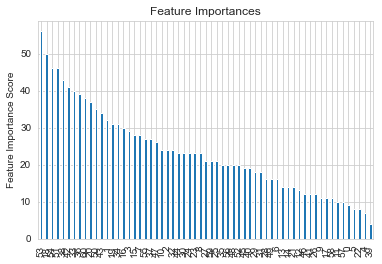

In [84]:
best_model = XGBRegressor(learning_rate=0.071,
                            n_estimators=112, max_depth=4, min_child_weight=4, gamma=0.2, 
                            subsample=0.6, colsample_bytree=0.6,
                            reg_alpha=0.01, reg_lambda=0.01, 
                            objective='reg:squarederror', 
                            nthread=4, 
                            scale_pos_weight=1,
                            seed=3612
                            )

## fit the model
best_model_cv = model_fit(best_model, X_train_t2, y_train_t2)
# best_model.fit(X_train_t2, y_train_t2)

In [93]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred_valid = best_model_cv.predict(X_valid_t2)
print("RMSE:", np.sqrt(mean_squared_error(y_valid_t2, y_pred_valid)))
print("R2:", r2_score(y_valid_t2, y_pred_valid))


RMSE: 0.21983975971515404
R2: 0.18720396318658228


In [89]:
best_model = XGBRegressor(learning_rate=0.071,
                            n_estimators=112, max_depth=4, min_child_weight=4, gamma=0.2, 
                            subsample=0.6, colsample_bytree=0.6,
                            reg_alpha=0.01, reg_lambda=0.01, 
                            objective='reg:squarederror', 
                            nthread=4, 
                            scale_pos_weight=1,
                            seed=3612
                            )

## fit the model
best_model = best_model.fit(X_train_t2, y_train_t2)
# best_model.fit(X_train_t2, y_train_t2)

In [92]:
y_pred_valid = best_model.predict(X_valid_t2)
print("RMSE:", np.sqrt(mean_squared_error(y_valid_t2, y_pred_valid)))
print("R2: ", r2_score(y_valid_t2, y_pred_valid))

RMSE: 0.21983975971515404
R2:  0.18720396318658228


In [ ]:
# store the model
pickle.dump(best_model, open(os.path.join(path_y_t2, 'best_model_v1.pkl'), "wb"))